In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Microplane Theory - 2D Elastic example

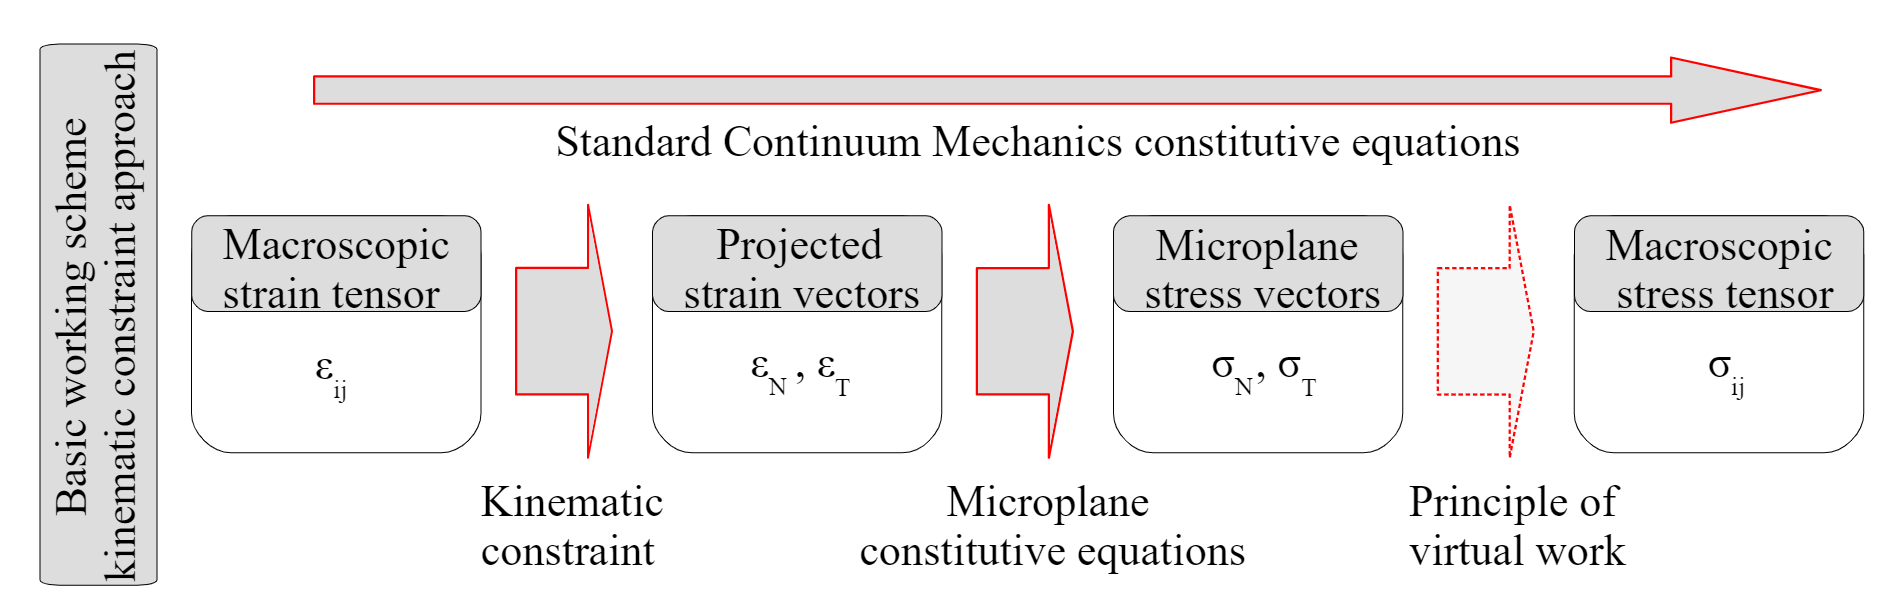

# Kinematic constraint - projecting strain tensor onto microplanes

## Construction of strain tensor

In [2]:
n_dim = 2
n_mp = 360
n_steps = 1000
delta = np.identity(n_dim)

In [3]:
epsilon_11 = np.linspace(0,-0.0001,n_steps) 

In [4]:
epsilon_ij = np.zeros((len(epsilon_11),n_dim,n_dim))

In [5]:
epsilon_ij[:,0,0] = epsilon_11

## Kinematic constraint - equations

\begin{align}
&\varepsilon_\mathrm{N} = \boldsymbol{N} :  \boldsymbol{\varepsilon}, \\ 
&\boldsymbol{\varepsilon_\mathrm{T}}=\boldsymbol{\mathrm{T}} :  \boldsymbol{\varepsilon},
\end{align}

where $\boldsymbol{N}$ is the rank two tensor, and $\boldsymbol{T}$ is the rank three tensor obtained as follows
\begin{align}
\boldsymbol{N} &= \boldsymbol{n}  \otimes  \boldsymbol{n}, \\
\boldsymbol{\mathrm{T}} &= \boldsymbol{n}  \cdot \boldsymbol{\mathbb{I}}_{\mathrm{sym}} - \boldsymbol{n}  \otimes  \boldsymbol{n}  \otimes  \boldsymbol{n},
\end{align}

## Constructing operators  $\boldsymbol{N}$ and  $\boldsymbol{T}$ and applying kinematic constraint

In [6]:
class IntegScheme():

    n_mp = 360
    alpha_list = np.linspace(0, 2 * np.pi, n_mp)
    # arrays of normal vector components
    MPN = np.array([[np.cos(alpha), np.sin(alpha)]
                        for alpha in alpha_list])
    # weights of ecah microplane
    MPW = np.ones(n_mp) / n_mp * 2
    delta = np.identity(2)
    """Get the operator of the microplane normals
    """
    MPNN_nij = np.einsum('ni,nj->nij', MPN, MPN)
    """Rank three tangential tensor (operator) for each microplane
    """
    MPTT_nijr = 0.5 * (
                np.einsum('ni,jr -> nijr', MPN, delta) +
                np.einsum('nj,ir -> njir', MPN, delta) - 2 *
                np.einsum('ni,nj,nr -> nijr', MPN, MPN, MPN))

    

In [7]:
# get the normal strain vector array for each microplane
e_N = np.einsum('nij,...ij->...n', IntegScheme.MPNN_nij, epsilon_ij)
# get the tangential strain vector array for each microplane
MPTT_ijr = IntegScheme.MPTT_nijr
e_V_norm = np.einsum('...ij,...ij ->...',delta,epsilon_ij)/3
e_V = np.einsum('ij,i->ij',np.ones_like(e_N),e_V_norm)
e_T_r = np.einsum('nija,...ij->...na', MPTT_ijr, epsilon_ij)
e_T = np.linalg.norm(e_T_r,axis=-1)

In [8]:
e_T_r.shape

(1000, 360, 2)

In [9]:
e_D = e_N - e_V

## Polar plots

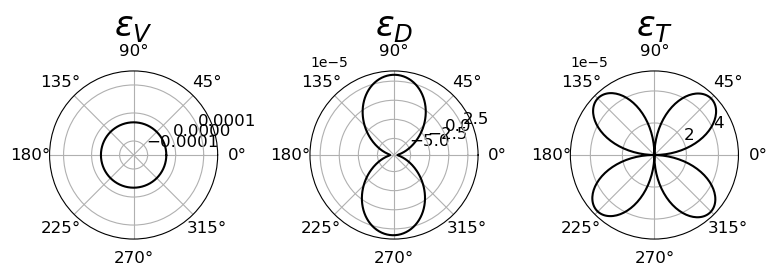

In [10]:
#%matplotlib widget
cm = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(20*cm, 10*cm))
rads = np.arange(0, (2 * np.pi), (2 * np.pi) / n_mp)
plt.subplot(131, projection='polar')
plt.plot(rads, e_V[-1, :], 'k')
plt.ylim(-1.5 * np.max(np.abs(e_N)),
                 1.5 * np.max(np.abs(e_N)))
plt.title(r'$\varepsilon_V$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(132, projection='polar')
plt.plot(rads,e_D[-1, :], 'k')
plt.title(r'$\varepsilon_D$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(133, projection='polar')
plt.plot(rads, np.linalg.norm(e_T_r[-1, :],axis=-1), 'k')
plt.title(r'$\varepsilon_T$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=12)


plt.tight_layout()

# Constitutive equation - elasticity

In [11]:
# NOTE: Here you were still taking random values for E_D, EV and so on!

E = 25000 #MPa
E_0 = 20000 #MPa
poisson = 0.18
E_N_0 = E / (1 - 2 * poisson) #MPa 
E_V_0 = E / (1 - 2 * poisson) #MPa
E_D_0 = E / (1 + poisson)  #MPa
E_T_0 = E / (1 + poisson) #MPa
f_c0prime=15.08 #MPa
f_cprime=20  #Mpa

## Compressive deviatoric boundary

In [25]:
s_D = np.zeros_like(e_D)
s_D_bound = np.zeros_like(e_D)
c_5 = 3500
c_6 = 20
c_7 = 1
c_8 = 8
c_9 = 0.012
k_1 = 0.00015
gama_0 = (f_c0prime/E_0) - (f_cprime/E)
e_0Nplus=np.zeros(n_mp)
e_0Nminus=np.zeros(n_mp)
#loop over each time step
#c_5_space = np.linspace(0,1,10)
#for c_5 in c_5_space:
for j in range(n_steps): 
    #loop over each microplane
    for i in range(n_mp):
        # predictor for compressive deviatoric stress
        s_D[j][i] = E_D_0 * e_D[j][i]
        # obtaining deviatoric compressive strain boundary (threshold)
        gama_1=np.exp(gama_0)*np.tanh(c_9*(max(-e_V[j][i],0))/k_1)  #Formula 18 #NOTE: here you need to implement Macauley brackets for e_V (I did it now)
        bita_2=c_5*gama_1+c_7  #Formula 17
        bita_3=c_6*gama_1+c_8  #Formula 17
        s_D_bound[j][i]=-E*k_1*bita_3/(1+((max(-e_D[j][i],0)/k_1*bita_2)**2))   #Formula 16  #NOTE: you wrote E_D, in Eq. 16 it sayes E, NOTE: e_D you have it in Macauley brackets
        # checking if we are crossing the boundary for time step j and microplane i
        if e_N[j][i] < 0:
            # print("comp.")
            # if we cross boundary, correct microplane i stress
            if s_D[j][i] > s_D_bound[j][i]: # NOT: if we cross s_D MUST be larger than s_D_bound
                # corrector deviatoric stress
                s_D[j][i] = s_D_bound[j][i]
        # further boundary
        # are we in tension?
        if e_N[j][i] > 0:
            if e_N[j][i] > e_0Nplus[i]:
                e_0Nplus[i] = e_N[j][i]  # NOTE: are e_0Nplus and e_0Nminus microplane state variables=? it looks like that, check it. If so, correct it ([j][i])       
        # are we in compression?    
        if e_N[j][i] < 0: 
            if e_N[j][i] < e_0Nminus[i]:
                e_0Nminus[i] = e_N[j][i]
         

## Volumetric boundary

In [26]:
s_V = np.zeros_like(e_V)
s_V_bound = np.zeros_like(e_V)
k_1= 0.00015
k_4= 100
k_3= 30
k_5= 0.0001
c_20= 1.8
poisson= 0.18
E_N_0 = E / (1 - 2 * poisson)
for j in range(1,n_steps):  # NOTE: here you needed to start your simulation form j=1 so that you can take j=0 by the first epsilon_ij[j-1]
    epsI = np.max(np.linalg.eig(epsilon_ij[j])[0])  
    epsII = np.min(np.linalg.eig(epsilon_ij[j])[0])
    for i in range(n_mp):
        s_V_0  = s_V[j-1][i] 
        # predictor for compressive volumetric stress
        e_e = np.max([-s_V_0/E_N_0 ,0])
        a=(k_5/(1+e_e))*(((epsI-epsII)/k_1)**(c_20))+k_4   # Formula 14  # NOTE: epsI and epsII are scalar values (eigenvalues) that are constant during the whole time step
        s_V[j][i] = E_V_0 * e_V[j][i] #s_V[j][i]= s_V_0 + E_V * (e_V[j][i] - e_V[j-1][i]) 
        s_V_bound[j][i] = -E*k_1*k_3*np.exp(-e_V[j][i]/(k_1*a))     #Formula 13
         # checking if we are crossing the boundary for time step j and microplane i
        # if e_V[j][i] < 0: # NOTE: Why are you checking here if the volummetric strain is negative?
            # if we cross boundary, correct microplane i stress
        if s_V[j][i] > s_V_bound[j][i]:
            # corrector normal stress
            s_V[j][i] = s_V_bound[j][i]

In [41]:
sigma_v = np.einsum('...n,...n->...',s_V,IntegScheme.MPW)

## Normal tensile boundary

In [27]:
s_N_bound = np.zeros_like(e_N)
s_N = np.zeros_like(e_N)
E_N = np.ones_like(e_N) * E_N_0
poisson= 0.18
c_1 = 0.089
c_2 = 0.176
c_3 = 4
c_4 = 50
c_13 = 4500
c_14 = 300
c_15 = 4000
c_16 = 60
c_17 = 1.4
c_18 = 0.0016
c_19 = 1000
e_0Nplus=np.zeros(n_mp)
e_0Nminus=np.zeros(n_mp)
#loop over each time step
for j in range(n_steps): 
    #loop over each microplane
    for i in range(n_mp):
        s_N_0 = (e_N[j-1][i]*E_N_0)
        if s_N_0 >= 0:
            if (e_N[j][i] - e_N[j-1][i])>=0:
                E_N[j][i] = E_N_0*np.exp(-c_13*e_0Nplus[i])     #Formula 19 # NOTE: are e_0Nplus and e_0Nminus microplane state variables=? it looks like that, check it. If so, correct it ([j][i])  
            else:
                E_N[j][i] = E_N_0     #Formula 20
        else:
            E_N[j][i] = E_N_0*(np.exp((-c_14*np.absolute(e_0Nminus[i]))/(1+c_15*e_e))+c_16*e_e)      #Formula 21 # NOTE: are e_0Nplus and e_0Nminus microplane state variables=? it looks like that, check it. If so, correct it ([j][i])  
                                                                                                     # NOTE e_e WRONG. you are taking the last e_e value calculated some other place, CHECK IT. Is it a microplane state variable or from the material point?
        # obtaining normal tensile strain boundary (threshold)
        bita_1=-c_1 + (c_17)*np.exp(-c_19*(e_e - c_18))     #Formula 23 NOTE : in paper it sayes tensile normal boundary, why did you write compressive??
        s_N_bound[j][i]=E*k_1*bita_1*np.exp(-(e_N[j][i]-bita_1*c_2*k_1)/(-c_4*e_e*np.sign(e_e)+k_1*c_3))    #Formula 23 # NOTE: here check e_e again!
        # checking if we are crossing the boundary for time step j and microplane i
        # print(s_N[j][i], s_N[j-1][i], E_N, e_N[j][i], e_N[j-1][i])
        s_N[j][i] = s_N[j-1][i] + E_N[j][i] * (e_N[j][i] - e_N[j-1][i])     #Formula 22
        # print(s_N_bound)
        if s_N[j][i]>0:
            if s_N[j][i] > s_N_bound[j][i]:
                s_N[j][i] = s_N_bound[j][i]
        s_N[j][i]= max(min(s_N[j][i], s_N_bound[j][i]), s_V_bound[j][i]+s_D_bound[j][i])     #Formula 24 #NOTE: s_V_bound and s_V_bound depend on each microplane and time step!!

## Tangential

In [29]:
s_T_bound = np.zeros_like(e_V)
s_tau = np.zeros_like(e_V)
s_T = np.zeros_like(e_V)
s_T_r = np.zeros_like(e_T_r)
s_hat_N = np.zeros_like(e_V)
s_T_e = np.zeros_like(e_V)
c_10=0.33
c_11=0.5
c_12=2.36
k_1= 0.00015
k_2= 110

for j in range(1,n_steps): 
    #loop over each microplane
    for i in range(n_mp):
        s_hat_N[j-1][i]=max((E_T_0*k_1*c_11)-(c_12*max(e_V[j][i],0) ) , 0)        # Eq. 26 # s_hat_N is in Macauley brackets!!
        s_T_e[j][i] = (e_T[j-1][i]*E_T_0)+E_T_0*(e_T[j][i] - e_T[j-1][i])  # Formula 29
        if s_N[j][i]<=0:
            s_T_bound[j][i]=(((c_10*(max(s_hat_N[j-1][i]-s_N[j][i],0)))**-1)+(E_T_0*k_1*k_2)**-1)**-1   #Formula 27 Macauley brackets!!
            # print(s_T_e[j][i])
            if s_T_e[j][i] > s_T_bound[j][i]:
                s_T_e[j][i] = s_T_bound[j][i]
        else :
            # print(s_T_bound[j][i])
            s_T_bound[j][i]=(((c_10* s_hat_N[j-1][i])**-1)+(E_T_0*k_1*k_2)**-1)**-1    #Formula 28
            # print(s_T_e[j][i], s_T_bound[j][i])
            if s_T_e[j][i] > s_T_bound[j][i]:
                s_T_e[j][i] = s_T_bound[j][i]
                
        s_tau[j][i]=min(s_T_bound[j][i],np.absolute(s_T_e[j][i]))    #Formula 30
        if s_T_e[j][i] > 0.0:
            s_T[j][i]=((e_T[j-1][i]*E_T_0)+E_T_0*(e_T[j][i] - e_T[j-1][i]))*s_tau[j][i]/s_T_e[j][i]    #Formula 31
        else:
            s_T[j][i] = 0.0

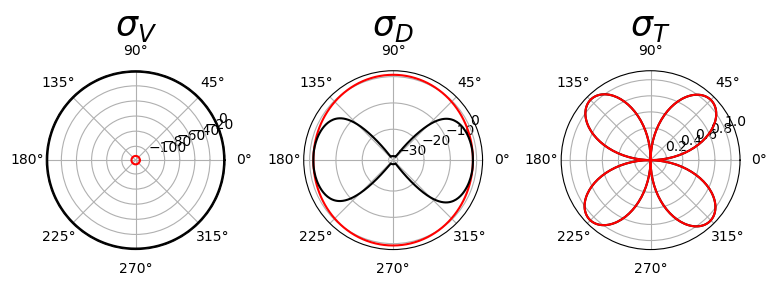

In [30]:
#%matplotlib widget
s_N_predictor = E_N_0 * e_N
s_V_predictor = E_V_0 * e_V
s_D_predictor = E_D_0 * e_D
s_T_r = E_T_0 * e_T_r

########SIGMA=V/D twig plot 131 132 133 

cm = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(20*cm, 10*cm))
rads = np.arange(0, (2 * np.pi), (2 * np.pi) / n_mp)
plt.subplot(131, projection='polar')
plt.plot(rads, s_V_predictor[-1, :], 'k')
plt.plot(rads, s_V[-1, :], 'r')
plt.title(r'$\sigma_V$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(132, projection='polar')
plt.plot(rads, s_D_predictor[-1, :], 'r')
plt.plot(rads, s_D[-1, :], 'k')
plt.title(r'$\sigma_D$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(133, projection='polar')
# for i in range(len(s_T)):
plt.plot(rads, (s_T[-1, :]), 'k')
plt.plot(rads, np.linalg.norm(s_T_r[-1, :],axis=-1), 'r')
plt.title(r'$\sigma_T$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=10)


plt.tight_layout()

## Polar plot

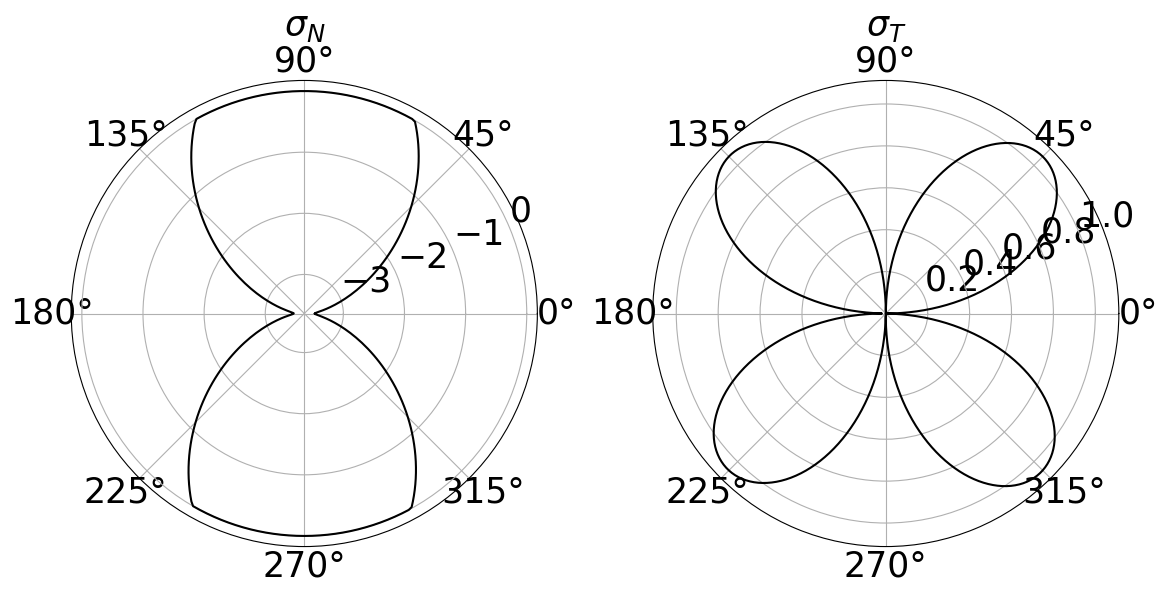

In [31]:
#%matplotlib widget
cm = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(30*cm, 15*cm))
rads = np.arange(0, (2 * np.pi), (2 * np.pi) / n_mp)
plt.subplot(121, projection='polar')
plt.plot(rads, s_N[-1, :], 'k')
plt.title(r'$\sigma_N$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)

plt.subplot(122, projection='polar')
plt.plot(rads, np.linalg.norm(s_T_r[-1, :],axis=-1), 'k')
plt.title(r'$\sigma_T$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)


plt.tight_layout()

## Stress-strain curve of a single microplane

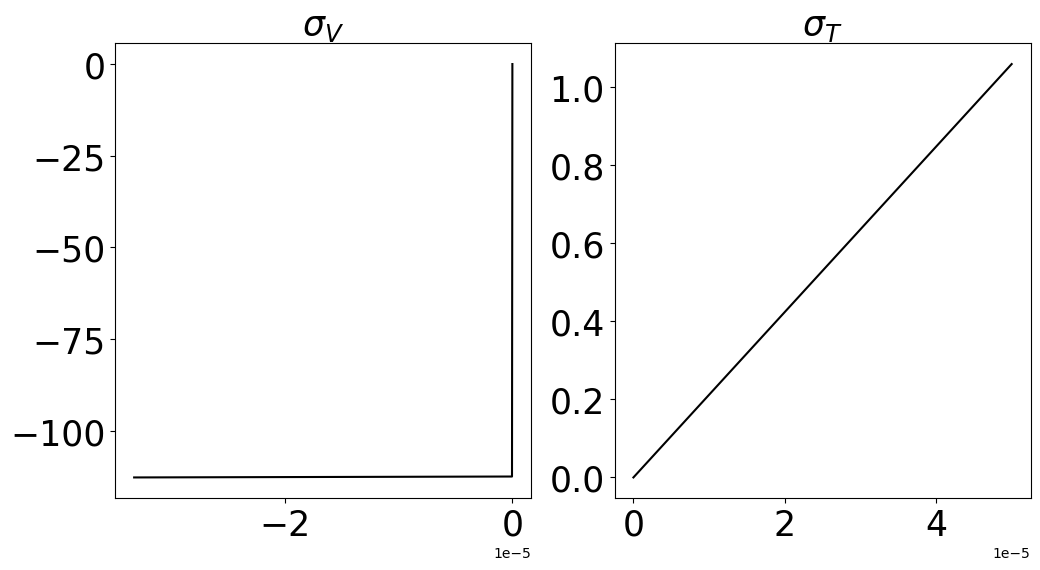

In [32]:
#%matplotlib widget
microplane = 45 #46°
cm = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(30*cm, 15*cm))
plt.subplot(121)
plt.plot(e_V[:, microplane], s_V[:, microplane], 'k')
plt.title(r'$\sigma_V$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)

plt.subplot(122)
plt.plot(np.linalg.norm(e_T_r[:, microplane],axis=-1), np.linalg.norm(s_T_r[:, microplane],axis=-1), 'k')
plt.title(r'$\sigma_T$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)


# Integrating $\sigma$ via PWV

\begin{align}
\sigma_{ij} = \frac{3}{2 \pi} \int_{\Omega}  \sigma^{\mathrm{mic}}_\mathrm{N}  n_i n_j  d \Omega + \frac{3}{2 \pi} \int_{\Omega} \frac{\sigma^{\mathrm{mic}}_{\mathrm{T}r}}{2} (n_i  \delta_{rj} + n_j \delta_{ri}) d \Omega.
\end{align}


In [63]:
sigma_ij = (
                np.einsum('n,...n,na,nb->...ab',
                          IntegScheme.MPW, s_N, IntegScheme.MPN, IntegScheme.MPN) +
                0.5 * (
                        np.einsum('n,...nf,na,fb->...ab',
                                  IntegScheme.MPW, s_T, IntegScheme.MPN, delta) +
                        np.einsum('n,...nf,nb,fa->...ab',
                                  IntegScheme.MPW, s_T, IntegScheme.MPN, delta)
                )
        )

In [65]:
s_T.shape

(360, 2)

In [64]:
#%matplotlib widget
microplane = 45
cm = 1 / 2.54  # centimeters in inches
plt.figure(figsize=(30*cm, 15*cm))
plt.subplot(121)
plt.plot(epsilon_ij[:, 0,0], sigma_ij[:, 0,0], 'k')
plt.title(r'$\sigma_{00}$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)

plt.subplot(122)
plt.plot(epsilon_ij[:, 0,0], sigma_ij[:, 1,1], 'k')
plt.title(r'$\sigma_{11}$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=25)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Microplane Theory - simple damage 

For the normal tensile behavior governed purely by damage, an additional threshold function is introduced as

\begin{align} \label{eq:damage_threshold_N}
&f_\mathrm{N}^{\omega} = Y_\mathrm{N} - (Y^0_\mathrm{N} + R_\mathrm{N}) \leq 0,
\end{align}

where the threshold of the energy release rate $Y^0_\mathrm{N}$ is defined as

\begin{equation}
Y^0_\mathrm{N} = \frac{1}{2} E_\mathrm{N} (\varepsilon^0_\mathrm{N})^2.
\end{equation}
Here, $\varepsilon^0_\mathrm{N}$ is the damage threshold of the tensile normal strain.

In a similar way, evolution equations governing the normal tension-separation behavior of a microplane can be obtained by differentiating  the damage threshold function with respect to the conjugate thermodynamic forces
\begin{align}
\label{eq:omega_N}
&\dot{\omega}_\mathrm{N} = \dot{\lambda}_\mathrm{N}^{\omega} \frac{\partial f_\mathrm{N}^{\omega}}{\partial Y_\mathrm{N}} = \dot{\lambda}_\mathrm{N}^{\omega}\\[0mm]
\label{eq:r_N}
&\dot{r}_\mathrm{N} = - \dot{\lambda}_\mathrm{N}^{\omega} \frac{\partial f_\mathrm{N}^{\omega}}{\partial R_\mathrm{N}} = - \dot{\lambda}_\mathrm{N}^{\omega}.
\end{align}

By substituting for $\dot{\lambda}_\mathrm{N}^\omega$ in the damage evolution function
and integrating it over the time domain, the damage function for normal direction is obtained as


\begin{equation} \label{eq:damage_function}
\omega (\varepsilon_\mathrm{N}) = 1 - \dfrac{1}{1 + A_\mathrm{d}(Y_\mathrm{N}(\varepsilon_\mathrm{N}) - Y_0 )}.
\end{equation}

In [15]:
e_N = np.linspace(0,0.01,n_steps)
Ad = 1000
eps_0 = 1e-5
E_N = 50000

In [16]:
def R_N(r_N_Emn): return (1.0 / Ad) * (-r_N_Emn / (1.0 + r_N_Emn))

Y_N = 0.5 * tension * E_N * (eps_N) ** 2.0
Y_0 = 0.5 * E_N * eps_0 ** 2.0

def f_w(Y): return 1.0 - 1.0 / (1.0 + self.Ad * (Y - Y_0))

omega_N[f > 1e-6] = f_w(Y_N)[f > 1e-6]
omega_N[...] = np.clip(omega_N, 0, 1.0)
r_N[f > 1e-6] = -omega_N[f > 1e-6]

NameError: name 'tension' is not defined